<a href="https://colab.research.google.com/github/mgcr271/deep-learning-with-r-notebooks/blob/master/notebooks/2.1-a-first-look-at-a-neural-network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages('keras')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




***

This notebook contains the code samples found in Chapter 2, Section 1 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

Let's look at a concrete example of a neural network that uses the Keras R package to learn to classify hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this first example right away. You probably haven't even installed Keras yet. Don't worry, that is perfectly fine. In the next chapter, we will review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! We've got to start somewhere.

The problem we're trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels) into their 10 categories (0 to 9). We'll use the MNIST dataset, a classic dataset in the machine-learning community, which has been around almost as long as the field itself and has been intensively studied. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST as the "Hello World" of deep learning—it's what you do to verify that your algorithms are working as expected. As you become a machine-learning practitioner, you'll see MNIST come up over and over again, in scientific papers, blog posts, and so on. 

The MNIST dataset comes preloaded in Keras, in the form of `train` and `test` lists, each of which includes a set of images (`x`) and associated labels (`y`):

In [0]:
library(keras)

mnist <- dataset_mnist()
train_images <- mnist$train$x
train_labels <- mnist$train$y
test_images <- mnist$test$x
test_labels <- mnist$test$y

`train_images` and `train_labels` form the _training set_, the data that the model will learn from. The model will then be tested on the  _test set_, `test_images` and `test_labels`. The images are encoded as as 3D arrays, and the labels are a 1D array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

The R `str()` function is a convenient way to get a quick glimpse at the structure of an array. Let's use it to have a look at the training data:

In [4]:
str(train_images)

 int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
str(train_labels)

 int [1:60000(1d)] 5 0 4 1 9 2 1 3 1 4 ...


Let's have a look at the test data:

In [6]:
str(test_images)

 int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...


In [7]:
str(test_labels)

 int [1:10000(1d)] 7 2 1 0 4 1 4 9 5 9 ...


The workflow will be as follows: first we'll feed the neural network the training data, `train_images` and `train_labels`. The network will then learn to associate images and labels. Finally, we'll ask the network to produce predictions for `test_images`, and we'll verify whether these predictions match the labels from `test_labels`.

Let's build the network -- again, remember that you aren't supposed to understand everything about this example yet.

In [0]:
network <- keras_model_sequential() %>% 
  layer_dense(units = 512, activation = "relu", input_shape = c(28 * 28)) %>% 
  layer_dense(units = 10, activation = "softmax")

The core building block of neural networks is the _layer_, a data-processing module that you can think of as a filter for data. Some data comes in, and it comes out in a more useful form. Specifically, layers extract _representations_ out of the data fed into them—hopefully representations that are more meaningful for the problem at hand. Most of deep learning consists of chaining together simple layers that will implement a form of progressive _data distillation_. A deep-learning model is like a sieve for data processing, made of a succession of increasingly refined data filters—the layers.

Here our network consists of a sequence of two layers, which are densely connected (also called _fully connected_) neural layers. The second (and last) layer is a 10-way _softmax_ layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make the network ready for training, we need to pick three more things, as part of the _compilation_ step:

* _A loss function_—How the network will be able to measure how good a job it's doing on its training data, and thus how it will be able to steer itself in the right direction.
* _An optimizer_—The mechanism through which the network will update itself based on the data it sees and its loss function.
* _Metrics to monitor during training and testing_—Here we'll only care about accuracy (the fraction of the images that were correctly classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next two chapters.

In [0]:
network %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

Before training, we'll preprocess the data by reshaping it into the shape the network expects and scaling it so that all values are in the `[0, 1]` interval. Previously, our training images, for instance, were stored in an array of shape `(60000, 28, 28)` of type integer with values in the `[0, 255]` interval. We transform it into a double array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [0]:
train_images <- array_reshape(train_images, c(60000, 28 * 28))
train_images <- train_images / 255

test_images <- array_reshape(test_images, c(10000, 28 * 28))
test_images <- test_images / 255

We also need to categorically encode the labels, a step which we explain in chapter 3:

In [0]:
train_labels <- to_categorical(train_labels)
test_labels <- to_categorical(test_labels)

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: we "fit" the model to its training data.

In [0]:
history <- network %>% 
  fit(train_images, train_labels, epochs = 5, batch_size = 128, validation_split = 0.2)

Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

The history 

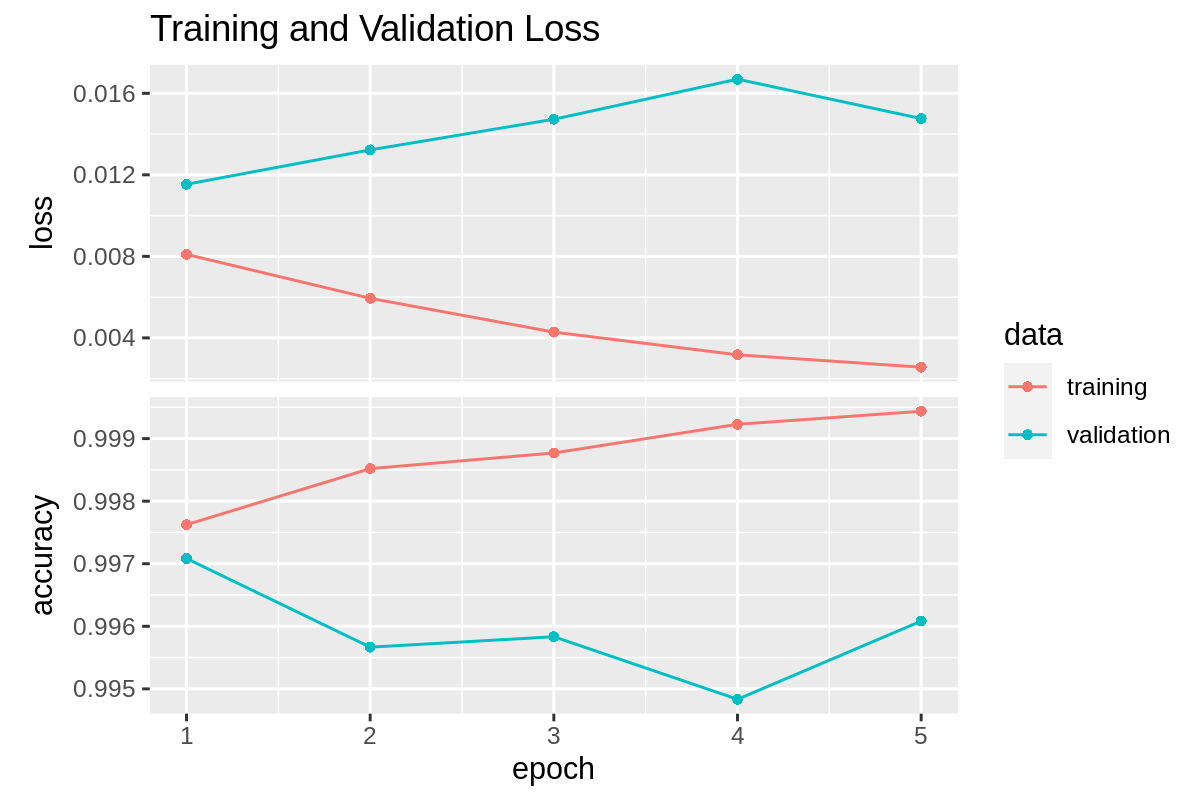

In [32]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)
plot(history) +
  ggplot2::geom_line() +
  ggplot2::labs(title = 'Training and Validation Loss')

In [33]:
metrics <- network %>% 
  evaluate(test_images, test_labels, verbose = 0)
metrics

loss   accuracy 
0.07929318 0.98379999

Our test set accuracy turns out to be 98.1% -- that's quite a bit lower than the training set accuracy. This gap between training accuracy and test accuracy is an example of "overfitting", the fact that machine learning models tend to perform worse on new data than on their training data. Overfitting will be a central topic in chapter 3.

This concludes our first example -- you just saw how you can build and a train a neural network to classify handwritten digits in less than 20 lines of R code. In the next chapter, we'll go into detail about every moving piece we just previewed and clarify what's going on behind the scenes. You'll learn about tensors, the data-storing objects going into the network; about tensor operations, which layers are made of; and about gradient descent, which allows your network to learn from its training examples.
